In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import gc

In [3]:
# Label encoder keeps the missing values...
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
import lightgbm as lgb

# Loading Data

In [5]:
train = pd.read_pickle('./data/train_pickle.pkl')

In [6]:
test = pd.read_pickle('./data/test_pickle.pkl')

In [7]:
feat_importance = pd.read_csv('./data/feature_importance.csv')

# Preprocessing:

We want to merge the two datasets and create a new target column (is_on_test):

In [8]:
train.drop('isFraud', axis=1, inplace=True)

In [9]:
train['is_on_test'] = 0
test['is_on_test'] = 1

In [10]:
data = pd.concat([train, test])
y = data['is_on_test']
data.drop('is_on_test', axis=1, inplace=True)

In [11]:
del train
del test
gc.collect()

48

Adding count of days from the start:

In [12]:
first_day = pd.date_range('2017-12-01', periods=1)[0]
data['days_from_start'] = (data['TransactionDT'] - first_day).dt.days

Normalizing D columns:

In [13]:
D_columns = ['D'+str(i) for i in range(1, 16)]

In [14]:
for col in D_columns:
    data[col+'_n'] = data['days_from_start'] - data[col]
    data.drop(col, axis=1, inplace=True)

Let's add some combinations of features that may identify card holder:

In [15]:
v_columns = ['V' + str(i) for i in range(1, 340)]

In [16]:
data.drop(v_columns, axis=1, inplace=True)

Encoding categorical labels with LabelEncoder (preserves NAs):

In [17]:
object_columns = [col for col in data.columns if data[col].dtype == object]

In [ ]:
for col in object_columns:
    lbl = LabelEncoder()
    lbl.fit(list(data[col].values))
    data[col] = lbl.transform(list(data[col].values))

Dropping columns that would make the task trivial:

In [ ]:
data.drop(['days_from_start','TransactionID','TransactionDT'], axis=1, inplace=True)

# Model:

In [102]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33,
                                                    random_state=42, shuffle=True)

In [103]:
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_test, y_test)

In [104]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 44,
         "metric": 'auc',
         "verbosity": -1}

In [105]:
num_round = 50
clf = lgb.train(param, train_dataset, num_round, 
                valid_sets = [train_dataset, test_dataset], 
                verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.998935	valid_1's auc: 0.998893
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.998935	valid_1's auc: 0.998893


We are able to separate training and test data almost perfectly with the available features. This shows that train and test datasets come from different distributions (or at least have some noise added that makes them identifiable).

Feature Importance:

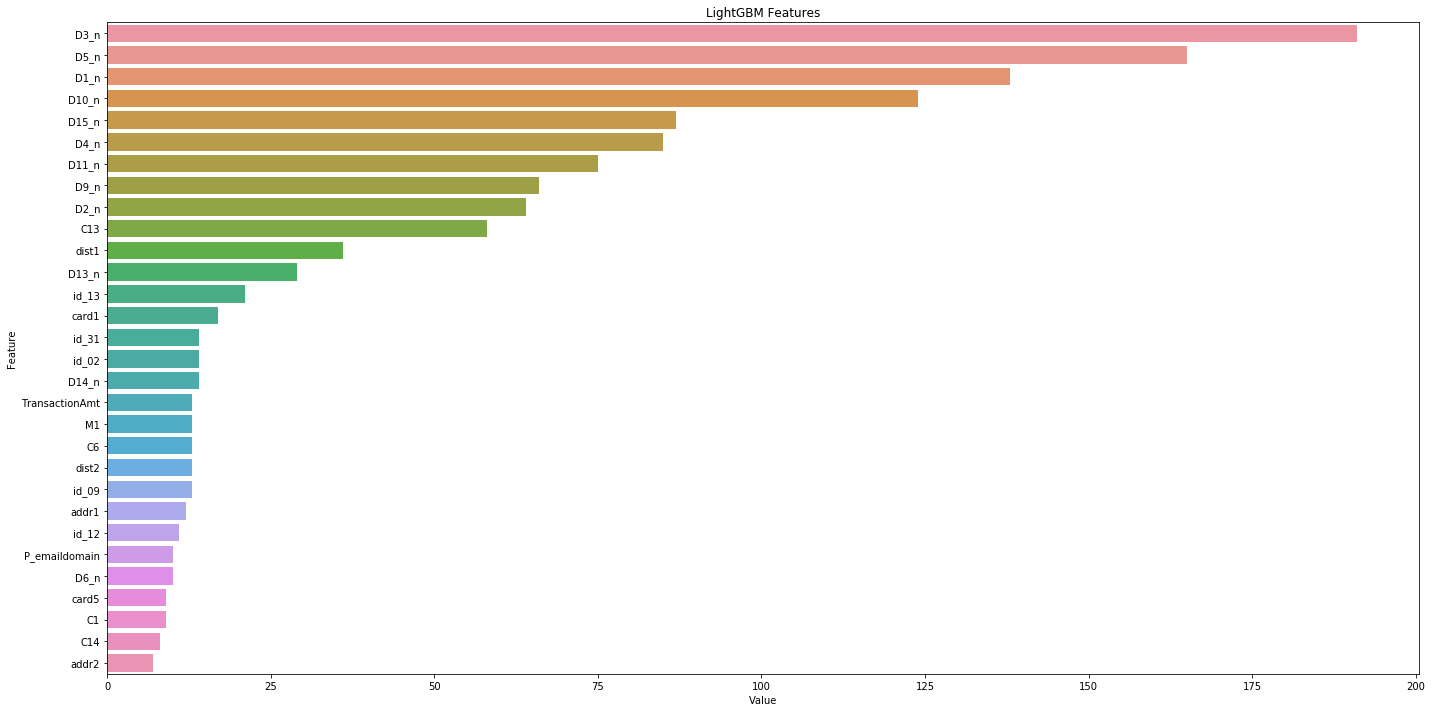

In [106]:
features = X_train.columns
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(30))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()